
# An Analysis of Toronto Roads and the Effect of Calming Features

##### By: Nelson Alesandro


The following Jupyter Notebook leverages the GeoPandas Python libraries  
and its dependencies to create plots and summaries based on analytical observations.

The purpose is to explore the relationship that calming features within roads have on traffic counts and collision rates.

This Notebook will show a step by step proccess, as well as rationale, that were taken to reach our conclusion.


# Importing, Cleaning, and Merging Data

#### Importing Libraries

The first thing we need to do is import all the libraries that we will use.

In [2]:
#Libraries for Data Manipulation
###########################
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
#see all dataframe columns when calling head on a dataframe
pd.set_option('display.max_columns', None)

#Libraries for geocoding
###########################
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3

#Libraries for Mapping
###########################
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import folium

#Libraries for Plotting data
###########################
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import matplotlib as mpl
import scipy.stats as pystat
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import branca
import branca.colormap as cm
import scipy

#Ignore copy warnings for dataframes
#The warnigns are meant to bring attention that a copy of data
#not the orignal is being manipulated. However manipulating copies
#  is the intended action at times.
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)

#Tell matplot lib to generate plots inline, within the notebook
%matplotlib inline


#### Importing and Creating Roads Shapefile

We import the Centreline data from the Open Data portal from the City of Toronto.  
This data set contains a variety of line features within Toronto, including: walkways, lake shores, railroads, and roads.

We plot the data and call .head() to see a general overview of its shape and confirm it is the data we need.

<Axes: >

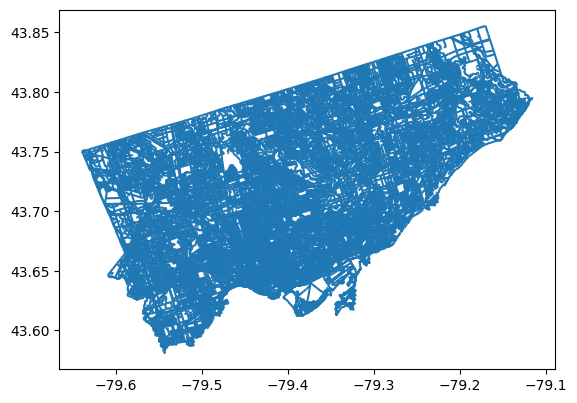

In [3]:
shape_path = "/workspace/GIS_project/data/Centreline - Version 2 - 4326/Centreline - Version 2 - 4326.shp"
centreline = gpd.read_file(shape_path)
centreline.plot()

In [4]:
centreline.head()

,_id1,CENTREL2,LINEAR_3,LINEAR_4,LINEAR_5,ADDRESS6,ADDRESS7,PARITY_8,PARITY_9,LO_NUM_10,HI_NUM_11,LO_NUM_12,HI_NUM_13,BEGIN_A14,END_ADD15,BEGIN_A16,END_ADD17,BEGIN_A18,END_ADD19,BEGIN_A20,END_ADD21,LOW_NUM22,HIGH_NU23,LOW_NUM24,HIGH_NU25,LINEAR_26,LINEAR_27,LINEAR_28,LINEAR_29,LINEAR_30,FROM_IN31,TO_INTE32,ONEWAY_33,ONEWAY_34,FEATURE35,FEATURE36,JURISDI37,CENTREL38,OBJECTI39,MI_PRIN40,geometry
0,1,914600,2141,Morrison St,Morrison Street,None,None,N,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Morrison,St,None,ET,Morrison St,13470555,13470560,0,Not One-Way,201500,Local,CITY OF TORONTO,None,1,1,"LINESTRING (-79.50875 43.59744, -79.50987 43.5..."
1,2,914601,2666,Twelfth St,Twelfth Street,66-92,65-89,E,O,66,92,65,89,1040061,1040085,1040060,1040082,66,92,65,89,65,89,66,92,Twelfth,St,None,None,Twelfth St,13470560,13470530,0,Not One-Way,201500,Local,CITY OF TORONTO,None,2,2,"LINESTRING (-79.50987 43.5972, -79.51035 43.59..."
2,3,7862398,2611,Thirteenth St,Thirteenth Street,66-96,65-91,E,O,66,96,65,91,7862400,7862422,7862399,7862415,66,96,65,91,65,91,66,96,Thirteenth,St,None,None,Thirteenth St,13470571,13470538,0,Not One-Way,201500,Local,CITY OF TORONTO,None,3,3,"LINESTRING (-79.51087 43.59697, -79.51134 43.5..."
3,4,914587,1962,Lake Shore Blvd W,Lake Shore Boulevard West,None,3180-3180,N,E,0,0,3180,3180,0,0,1013460,1013460,0,0,3180,3180,0,0,3180,3180,Lake Shore,Blvd,W,None,Lake Shore Blvd W,13470546,13470552,0,Not One-Way,201200,Major Arterial,CITY OF TORONTO,None,6,6,"LINESTRING (-79.51805 43.59795, -79.51914 43.5..."
4,5,6735911,1962,Lake Shore Blvd W,Lake Shore Boulevard West,3197-3197,3190-3190,O,E,3197,3197,3190,3190,6735910,6735910,6735913,6735913,3197,3197,3190,3190,3197,3197,3190,3190,Lake Shore,Blvd,W,None,Lake Shore Blvd W,13470552,13470558,0,Not One-Way,201200,Major Arterial,CITY OF TORONTO,None,7,7,"LINESTRING (-79.51914 43.5977, -79.52024 43.59..."


All we need however are the road features, and for the puproses of our observation we will exclude Expressways and their ramps.  
The reason for exlusion being that calming features like speed bumps or traffic islands are only on non-Expressway roads. So in order to get  
accurate analysis we want two sample groups that model the same amount of variables as closely as possible.

In [5]:
#We only want non motorway roads. So find feature types, and select the ones we want
centreline.FEATURE36.unique()


array(['Local', 'Major Arterial', 'River', 'Geostatistical line',
       'Major Shoreline', 'Collector', 'Minor Arterial', 'Major Railway',
       'Expressway', 'Laneway', 'Expressway Ramp', 'Pending',
       'Major Arterial Ramp', 'Other', 'Hydro Line', 'Walkway',
       'Minor Shoreline (Land locked)', 'Minor Railway', 'Trail',
       'Creek/Tributary', 'Collector Ramp', 'Busway', 'Ferry Route',
       'Access Road', 'Other Ramp', 'Minor Arterial Ramp'], dtype=object)

In [6]:
road_list = ['Local', 'Major Arterial', 'Major Arterial Ramp', 'Collector', 'Collector Ramp', 'Minor Arterial', 'Minor Arterial Ramp']
roads = centreline.query('FEATURE36 in @road_list')
roads = roads[['CENTREL2', 'LINEAR_3', 'LINEAR_4','LINEAR_5',
                'LINEAR_26', 'LINEAR_30', 'FROM_IN31', 'TO_INTE32', 'FEATURE35',
                'FEATURE36', 'JURISDI37', 'OBJECTI39', 'MI_PRIN40', 'geometry']]
roads.head()

,CENTREL2,LINEAR_3,LINEAR_4,LINEAR_5,LINEAR_26,LINEAR_30,FROM_IN31,TO_INTE32,FEATURE35,FEATURE36,JURISDI37,OBJECTI39,MI_PRIN40,geometry
0,914600,2141,Morrison St,Morrison Street,Morrison,Morrison St,13470555,13470560,201500,Local,CITY OF TORONTO,1,1,"LINESTRING (-79.50875 43.59744, -79.50987 43.5..."
1,914601,2666,Twelfth St,Twelfth Street,Twelfth,Twelfth St,13470560,13470530,201500,Local,CITY OF TORONTO,2,2,"LINESTRING (-79.50987 43.5972, -79.51035 43.59..."
2,7862398,2611,Thirteenth St,Thirteenth Street,Thirteenth,Thirteenth St,13470571,13470538,201500,Local,CITY OF TORONTO,3,3,"LINESTRING (-79.51087 43.59697, -79.51134 43.5..."
3,914587,1962,Lake Shore Blvd W,Lake Shore Boulevard West,Lake Shore,Lake Shore Blvd W,13470546,13470552,201200,Major Arterial,CITY OF TORONTO,6,6,"LINESTRING (-79.51805 43.59795, -79.51914 43.5..."
4,6735911,1962,Lake Shore Blvd W,Lake Shore Boulevard West,Lake Shore,Lake Shore Blvd W,13470552,13470558,201200,Major Arterial,CITY OF TORONTO,7,7,"LINESTRING (-79.51914 43.5977, -79.52024 43.59..."


We re-project the roads we chose into EPSG:26917, the local mapping projection for the Toronto area,  
also known as NAD83 / UTM zone 17N.  
A benefit of the reprojection is that the units we use for distance are now in meters, as specified by metadata of the projections.

We plot once more to visually check that the new road feature matches what we wanted.

<Axes: >

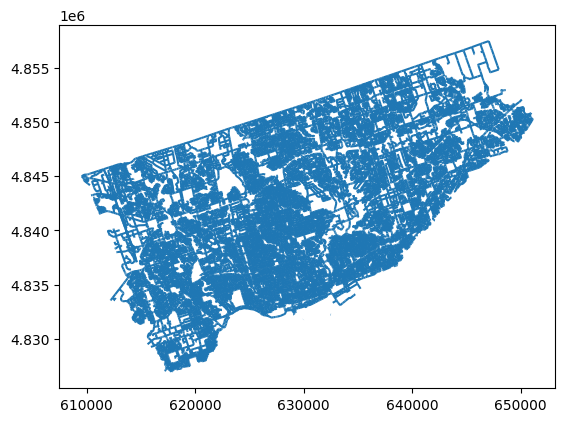

In [7]:
road_26917 = roads.to_crs(epsg=26917)
road_26917.plot()


#### Importing Calming Features Shapefile

Next we import the calming features database. This dataset contains the shapefile of all calming features within Toronto,  
including the name of the road they are located on.

In [8]:
file_path = "/workspace/GIS_project/data/Traffic Calming Database/Traffic Calming Database - 04.04.2023V2.shp"
calming_roads = gpd.read_file(file_path)

Once more we plot and check the data to make sure it lines up with what we expect.

<Axes: >

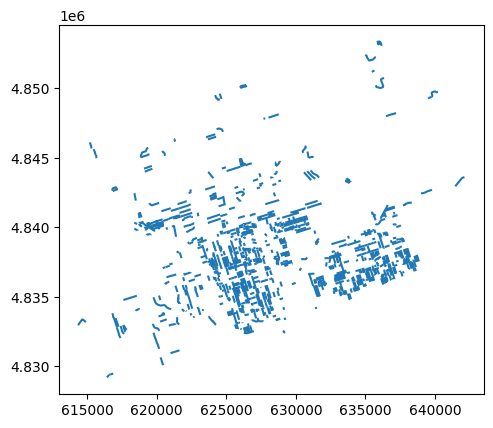

In [9]:
calming_roads = calming_roads.to_crs('epsg:26917')
calming_roads.plot()

In [10]:
calming_roads.head(-5)

,calm_id,street,intersecti,intersec_1,spd_hump,traf_islan,spd_cush,Installed,geometry
0,1.0,Oakridge Drive,Brimley Rd,McCowan Rd,8.0,0.0,0.0,2004,"LINESTRING (641464.739 4842951.003, 641507.965..."
1,3.0,Atlas Avenue,Gloucester Grove,Eglinton Avenue West,2.0,0.0,0.0,1999,"LINESTRING (625890.037 4839370.112, 625854.462..."
2,4.0,Balliol Street,Mt. Pleasant Road,Cleveland Street,2.0,0.0,0.0,1998,"LINESTRING (630028.385 4839752.147, 630387.961..."
3,5.0,Balmoral Avenue,Avenue Road,Yonge Street,6.0,0.0,0.0,1998,"LINESTRING (629505.289 4838240.561, 629455.886..."
4,6.0,Bartlett Avenue North,Geary Avenue,Davenport Road,6.0,0.0,0.0,1999,"LINESTRING (626022.276 4836406.392, 626006.544..."
...,...,...,...,...,...,...,...,...,...
855,2151.0,Rainsford Rd,Kingston Rd,Queen St E,NaN,NaN,4.0,2022,"LINESTRING (636495.803 4836447.656, 636480.886..."
856,2159.0,Roseheath Ave,Danforth Ave,Hanson St,NaN,NaN,4.0,2022,"LINESTRING (635672.31 4837829.833, 635667.053 ..."
857,2152.0,Scarboro Beach Blvd,Hubbard Blvd,Queen St E,NaN,NaN,3.0,2022,"LINESTRING (637568.753 4836791.877, 637582.565..."
858,2153.0,Scarborough Rd,Pine Ave,Queen St E,NaN,NaN,3.0,2022,"LINESTRING (638193.782 4837424.426, 638322.386..."


#### Combining Roads with Calming Features

One of the advantages of directly working with Python libraries rather than manually doing the tasks via ArcGIS or QGIS, is that
repetative tasks that are time consuming can be done with relative ease.

In this case what we are doing is grouping each feature by it's street name, and combining them with each other if they are within 5 meters.  
Because we are automating it we can iterate through thousand of street names in a matter of seconds.

The reason for this method rather than merging on the street name values or proximity is due to edge cases.  
If we were to merge on street names, there is a chance the either feature will match on a duplicate street  
name somewhere else in the city.

Alternatively, if we were to match soley by proximity, then if a calming feature was accidently offset during creation it might instead
match to an adjacent road connected to the one its supposed to be on.

If we were to do this manually we would need to match calming features 1:m to any roads within 5 meters, and then filter out non matching street names.  
Although tedious, not difficult, but we will see this process again later in the notebook on a process less likely to be done manually.

In [11]:
#split each dataframe into groups
calm_split = {k:d for k, d in calming_roads.groupby('street')}
road_split = {k:d for k, d in road_26917.groupby('LINEAR_5')}

#our new feature
combined_roads = pd.DataFrame()
for i in calm_split:
    #try is needed for when a road is present in one group, but not the other
    #causing a key value error
    try:
        #if shared road is present AND wihtin the distance then add to an already existing dataframe
        combined_roads = pd.concat([combined_roads, gpd.sjoin_nearest(road_split[i], calm_split[i], max_distance=5, how='right')])
    except:
        #otherwise we didn't need to add the data and can pass over it
        pass

#There can be multiple calming features per road, but we only care if a road has one or not, so we
#retrieve the max values on its properties.
#not using mode, since its likely a road may have two features, therefore returning an error on mode
combined_roads = combined_roads.drop(columns=['index_left', 'geometry'])
combined_roads = combined_roads.groupby('CENTREL2').agg('max')
#reset to remove groups
combined_roads = combined_roads.reset_index()

#only keep the columns we need
combined_roads = combined_roads[['CENTREL2', 'calm_id', 'spd_hump', 'traf_islan', 'spd_cush', 'Installed']]
combined_roads.head(-5)

,CENTREL2,calm_id,spd_hump,traf_islan,spd_cush,Installed
0,127.0,1329.0,4.0,0.0,0.0,2009
1,131.0,1329.0,4.0,0.0,0.0,2009
2,250.0,969.0,7.0,0.0,0.0,2005
3,377.0,1273.0,5.0,0.0,0.0,2008
4,515.0,1112.0,5.0,0.0,0.0,2006
...,...,...,...,...,...,...
740,30139823.0,473.0,5.0,0.0,0.0,2000
741,30141591.0,49.0,4.0,0.0,0.0,1999
742,30142944.0,156.0,7.0,0.0,0.0,2001
743,30142945.0,156.0,7.0,0.0,0.0,2001


Thanks to matching calming features to streets, calming featrures now share a common ID with roads,  
in which we can now use to merge back into the roads feature.

In [12]:
#add the calmed roads back into road using the new shared ids
road_26917 = road_26917.merge(combined_roads, how='left', on=['CENTREL2'], validate='1:1', suffixes=('_l', '_r'))
road_26917.to_file('road_26917.shp')
road_26917.head()

,CENTREL2,LINEAR_3,LINEAR_4,LINEAR_5,LINEAR_26,LINEAR_30,FROM_IN31,TO_INTE32,FEATURE35,FEATURE36,JURISDI37,OBJECTI39,MI_PRIN40,geometry,calm_id,spd_hump,traf_islan,spd_cush,Installed
0,914600,2141,Morrison St,Morrison Street,Morrison,Morrison St,13470555,13470560,201500,Local,CITY OF TORONTO,1,1,"LINESTRING (620365.778 4828243.398, 620275.681...",NaN,NaN,NaN,NaN,NaN
1,914601,2666,Twelfth St,Twelfth Street,Twelfth,Twelfth St,13470560,13470530,201500,Local,CITY OF TORONTO,2,2,"LINESTRING (620275.681 4828215.213, 620235.062...",NaN,NaN,NaN,NaN,NaN
2,7862398,2611,Thirteenth St,Thirteenth Street,Thirteenth,Thirteenth St,13470571,13470538,201500,Local,CITY OF TORONTO,3,3,"LINESTRING (620195.613 4828188.199, 620155.247...",NaN,NaN,NaN,NaN,NaN
3,914587,1962,Lake Shore Blvd W,Lake Shore Boulevard West,Lake Shore,Lake Shore Blvd W,13470546,13470552,201200,Major Arterial,CITY OF TORONTO,6,6,"LINESTRING (619614.26 4828286.233, 619526.218 ...",NaN,NaN,NaN,NaN,NaN
4,6735911,1962,Lake Shore Blvd W,Lake Shore Boulevard West,Lake Shore,Lake Shore Blvd W,13470552,13470558,201200,Major Arterial,CITY OF TORONTO,7,7,"LINESTRING (619526.218 4828257.126, 619438.216...",NaN,NaN,NaN,NaN,NaN


#### Importing Traffic Data

The Open Data set includes traffic data in the form of Comma Seperated Values (CSV), seperated by decade.  
So we will need to combine them first.

In [13]:
#read shapefiles
file_path_1 = "/workspace/GIS_project/data/traffic/raw-data-1990-1999.csv"
file_path_2 = "/workspace/GIS_project/data/traffic/raw-data-2000-2009.csv"
file_path_3 = "/workspace/GIS_project/data/traffic/raw-data-2010-2019.csv"
file_path_4 = "/workspace/GIS_project/data/traffic/raw-data-2020-2029.csv"
#combine the csvs into a single dataframe
traffic = pd.concat(
    map(pd.read_csv, [file_path_1, file_path_2, file_path_3, file_path_4]), ignore_index=True)
#display head data
traffic.to_csv("traffic.csv")
traffic.head(-5)

,_id,count_id,count_date,location_id,location,lng,lat,centreline_type,centreline_id,px,time_start,time_end,sb_cars_r,sb_cars_t,sb_cars_l,nb_cars_r,nb_cars_t,nb_cars_l,wb_cars_r,wb_cars_t,wb_cars_l,eb_cars_r,eb_cars_t,eb_cars_l,sb_truck_r,sb_truck_t,sb_truck_l,nb_truck_r,nb_truck_t,nb_truck_l,wb_truck_r,wb_truck_t,wb_truck_l,eb_truck_r,eb_truck_t,eb_truck_l,sb_bus_r,sb_bus_t,sb_bus_l,nb_bus_r,nb_bus_t,nb_bus_l,wb_bus_r,wb_bus_t,wb_bus_l,eb_bus_r,eb_bus_t,eb_bus_l,nx_peds,sx_peds,ex_peds,wx_peds,nx_bike,sx_bike,ex_bike,wx_bike,nx_other,sx_other,ex_other,wx_other
0,1,2891,1990-08-21,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,2178.0,1990-08-21T07:30:00,1990-08-21T07:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,324.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2891,1990-08-21,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,2178.0,1990-08-21T07:45:00,1990-08-21T08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2891,1990-08-21,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,2178.0,1990-08-21T08:00:00,1990-08-21T08:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2891,1990-08-21,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,2178.0,1990-08-21T08:15:00,1990-08-21T08:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,321.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2891,1990-08-21,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,2178.0,1990-08-21T08:30:00,1990-08-21T08:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,295.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838841,185100,101686,2024-07-09,51246,Sumach St / Shuter St,-79.359505,43.658301,2.0,30026352.0,2627.0,2024-07-09T15:15:00,2024-07-09T15:30:00,5.0,8.0,7.0,0.0,0.0,0.0,1.0,17.0,0.0,5.0,69.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,4.0,7.0,19.0,2.0,3.0,5.0,19.0,0.0,0.0,0.0,0.0
838842,185101,101686,2024-07-09,51246,Sumach St / Shuter St,-79.359505,43.658301,2.0,30026352.0,2627.0,2024-07-09T15:30:00,2024-07-09T15:45:00,3.0,7.0,7.0,0.0,0.0,0.0,2.0,22.0,2.0,4.0,55.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,3.0,10.0,25.0,3.0,8.0,3.0,16.0,0.0,0.0,0.0,0.0
838843,185102,101686,2024-07-09,51246,Sumach St / Shuter St,-79.359505,43.658301,2.0,30026352.0,2627.0,2024-07-09T16:00:00,2024-07-09T16:15:00,5.0,14.0,3.0,0.0,0.0,0.0,6.0,20.0,1.0,16.0,50.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,8.0,11.0,28.0,2.0,12.0,4.0,22.0,0.0,0.0,0.0,0.0
838844,185103,101686,2024-07-09,51246,Sumach St / Shuter St,-79.359505,43.658301,2.0,30026352.0,2627.0,2024-07-09T16:15:00,2024-07-09T16:30:00,1.0,4.0,6.0,0.0,0.0,0.0,5.0,26.0,3.0,6.0,53.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,6.0,12.0,37.0,5.0,8.0,2.0,36.0,0.0,0.0,0.0,0.0


#### Recalculating and Cleaning Traffic Data

The CSV's sperate traffic by mode of transportation, although we are only concerned with motor vehicles, such as cars, buses, and motorcycles, not pedestirans
or bikes.

We add up all the columns that have to motor traffic into a new column called 'motortraf'.  
We also calculate the year the count occured so that we can group them later.

Finally the new data, as well as essential data, is put into a new truncated dataframe, for easier manipulation.

In [14]:
#calculate new field that adds up all motor traffic
traffic['motortraf'] = traffic.loc[:,'sb_cars_r':'eb_bus_l'].sum(axis=1) + traffic.loc[:,'nx_other':'wx_other'].sum(axis=1)
#create a year field
traffic['year'] = pd.to_datetime(traffic['count_date']).dt.year

#new, cleaner, dataframe
traffic_trunc = traffic[['count_id', 'year', 'location_id', 'location', 'lng', 'lat', 'centreline_type', 'centreline_id', 'motortraf']]
traffic_trunc.head()

,count_id,year,location_id,location,lng,lat,centreline_type,centreline_id,motortraf
0,2891,1990,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,333.0
1,2891,1990,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,320.0
2,2891,1990,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,350.0
3,2891,1990,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,329.0
4,2891,1990,4614,ELINOR AVE AT LAWRENCE AVE (PX 2178),-79.300554,43.744099,2.0,13451060.0,309.0


The data is grouped by year and we calculate the sums of traffic for whole years, aggregating on each road.  
We use 'location_id', as it is the unique identifier for traffic count.

In [15]:
#aggregate and group by year and location id
traffic_agg = traffic_trunc.groupby(['year','location_id']).agg({'count_id': pd.Series.mode,
                                                              'location': pd.Series.mode,
                                                              'lng': pd.Series.mode, 'lat': pd.Series.mode,
                                                              'centreline_type':pd.Series.mode,
                                                              'centreline_id':pd.Series.mode,
                                                              'motortraf': 'sum'})
#reset index so that we can use the data frame
traffic_agg = traffic_agg.reset_index()
traffic_agg.head(-5)

,year,location_id,count_id,location,lng,lat,centreline_type,centreline_id,motortraf
0,1990,3943,2896,OCONNOR DR AT ST CLAIR AVE (PX 447),-79.312836,43.705396,2.0,13457092.0,25543.0
1,1990,3950,2899,KINGSTON RD AT BROOKLAWN AVE & ST CLAIR AVE E ...,-79.236019,43.722032,2.0,13454337.0,23234.0
2,1990,3976,3139,EGLINTON SQ AT O CONNOR DR & VICTORIA PARK AVE...,-79.302100,43.723380,2.0,13454288.0,23507.0
3,1990,3977,3178,DANFORTH AVE AT VICTORIA PARK AVE (PX 355),-79.288358,43.691232,2.0,13459445.0,22429.0
4,1990,3978,3243,EGLINTON AVE AT VICTORIA PARK AVE (PX 451),-79.302645,43.724723,2.0,13454107.0,38630.0
...,...,...,...,...,...,...,...,...,...
22833,2024,51160,101526,Allenvale Ave / Lauder Ave,-79.445359,43.692544,2.0,13459620.0,656.0
22834,2024,51161,101529,Oakwood Ave / Earlsdale Ave,-79.438091,43.685555,2.0,13460884.0,9187.0
22835,2024,51231,101538,Brunswick Ave / Lowther Ave,-79.408303,43.668037,2.0,13463884.0,910.0
22836,2024,51232,101541,Royal York Rd / Valiant Rd,-79.515116,43.655848,2.0,13466089.0,10564.0


After aggregating we need to map the new data into a geodataframe using the 'lng' and 'lat' fields as  
longitude and latitude.

This allows it to be plotted, and for use to perform spatial analysis.

<Axes: >

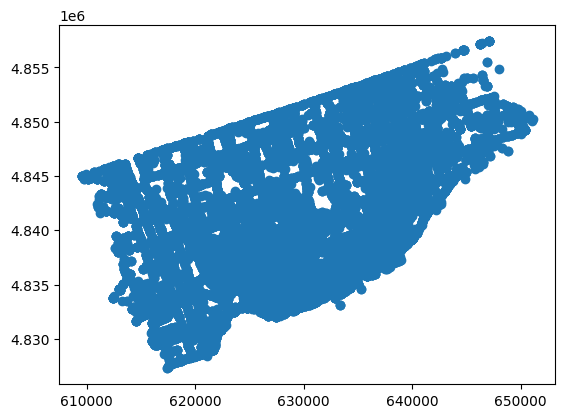

In [16]:
points = traffic_agg.apply(lambda row: Point(row.lng, row.lat), axis = 1)
#only keep traffic 2014 and after to line up with collisions
traffic_intersections = gpd.GeoDataFrame(traffic_agg, geometry=points)
#using metadate (filename) to initialize the data with the proper projection
traffic_intersections.crs = {'init': 'epsg:4326'}
traffic_26917 = traffic_intersections.to_crs(epsg=26917)
traffic_26917.plot()

#### Importing Collision Data

The collision data has information on collisions, with their location offeset to the nearest intersection.

In [17]:
collision = gpd.read_file('/workspace/GIS_project/data/Traffic Collisions - 4326/Traffic Collisions - 4326.shp')
collision.head(-5)

,_id1,OCC_DAT2,OCC_MON3,OCC_DOW4,OCC_YEA5,OCC_HOU6,DIVISIO7,FATALIT8,INJURY_9,FTR_COL10,PD_COLL11,HOOD_1512,NEIGHBO13,LONG_WG14,LAT_WGS15,AUTOMOB16,MOTORCY17,PASSENG18,BICYCLE19,PEDESTR20,geometry
0,1,1388552400000,January,Wednesday,2014,4,D43,0,YES,NO,NO,157,Bendale South (157),-79.25535525232044,43.75352197370893,YES,NO,YES,NO,NO,MULTIPOINT (-79.25536 43.75352)
1,2,1388552400000,January,Wednesday,2014,14,D14,0,NO,YES,NO,078,Kensington-Chinatown (78),-79.40601573209595,43.652310093633126,YES,NO,NO,NO,NO,MULTIPOINT (-79.40602 43.65231)
2,14,1388552400000,January,Wednesday,2014,1,D14,0,NO,NO,YES,086,Roncesvalles (86),-79.4286372237863,43.64220588807775,YES,NO,NO,NO,NO,MULTIPOINT (-79.42864 43.64221)
3,15,1388552400000,January,Wednesday,2014,14,D13,0,NO,NO,YES,101,Forest Hill South (101),-79.4178019320394,43.68673751185377,YES,NO,NO,NO,NO,MULTIPOINT (-79.4178 43.68674)
4,16,1388552400000,January,Wednesday,2014,2,D23,0,NO,NO,YES,007,Willowridge-Martingrove-Richview (7),-79.56313850270357,43.67441063320029,YES,NO,NO,NO,NO,MULTIPOINT (-79.56314 43.67441)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574219,687130,1719723600000,June,Sunday,2024,17,D33,0,NO,YES,NO,047,Don Valley Village (47),-79.34698765381663,43.775179913411826,YES,NO,NO,NO,NO,MULTIPOINT (-79.34699 43.77518)
574220,687131,1719723600000,June,Sunday,2024,19,D14,0,NO,NO,YES,080,Palmerston-Little Italy (80),-79.41706672764312,43.65516659990851,YES,NO,NO,YES,NO,MULTIPOINT (-79.41707 43.65517)
574221,687132,1719723600000,June,Sunday,2024,15,D51,0,NO,YES,NO,168,Downtown Yonge East (168),-79.3777897470096,43.65194899105262,YES,NO,NO,NO,NO,MULTIPOINT (-79.37779 43.65195)
574222,687133,1719723600000,June,Sunday,2024,18,D55,0,NO,NO,YES,066,Danforth (66),-79.32363123294031,43.68336521316597,YES,NO,NO,NO,NO,MULTIPOINT (-79.32363 43.68337)


#### Cleaning Collision Data

Some of the fields contain both numeric and string values, so we need to standardize the data into common types.

We are also only concerned with whether or not a motor collision occured and if there were injuries, not how many injuries were in a single crash. So the fields
are turned into a binary value, rather than 'YES', 'NO', or a number > 1.

We ignore NaN values, as they wont provide location data, they type of crash, or if injuries were present.

In [18]:
#create new field that we can sum up for total crashes in a year
collision['motorcol'] = collision.apply(lambda x: 1 if x['AUTOMOB16'] == 'YES' else 0, axis=1)
#change the number of fatalities into whether a fatal crash happened or not
collision['fatals'] = collision.apply(lambda x: 1 if x['FATALIT8'] > 0 else 0, axis=1)
#binary field for whether the crash had injuries, so we can sum up total amount of collisions with injuries
collision['injuries'] = collision.apply(lambda x: 1 if x['INJURY_9'] == 'YES' else 0, axis=1)
#aggregate and group by year and geometry

We sum up the collisions by year and location.

There is no location ID like there was with traffic, so we will have to rely on the geometry it self, which can be problamatic at times  
if data at two different location are meant to represent the same interestion. 

We hope to resolve this when we combine this data set with the traffic data set.

In [19]:
collision_agg = collision.groupby(['OCC_YEA5','geometry']).agg({'_id1': 'max',
                                                            'HOOD_1512': pd.Series.mode,
                                                            'NEIGHBO13': pd.Series.mode,
                                                            'motorcol':'sum',
                                                            'fatals':'sum',
                                                            'injuries': 'sum'})
collision_agg = collision_agg.reset_index()
collision_agg = collision_agg.rename(columns={'OCC_YEA5':'year'})
collision_agg.head(-5)

,year,geometry,_id1,HOOD_1512,NEIGHBO13,motorcol,fatals,injuries
0,2014,MULTIPOINT (-79.60451 43.64709),60064,011,Eringate-Centennial-West Deane (11),4,0,0
1,2014,MULTIPOINT (-79.60308 43.65156),59852,011,Eringate-Centennial-West Deane (11),6,0,1
2,2014,MULTIPOINT (-79.59005 43.64551),41959,011,Eringate-Centennial-West Deane (11),4,0,0
3,2014,MULTIPOINT (-79.5812 43.65095),61195,011,Eringate-Centennial-West Deane (11),5,0,0
4,2014,MULTIPOINT (-79.57949 43.6514),64462,013,Etobicoke West Mall (13),12,0,3
...,...,...,...,...,...,...,...,...
102844,2024,MULTIPOINT (-79.3792 43.64252),684870,166,St Lawrence-East Bayfront-The Islands (166),4,0,0
102845,2024,MULTIPOINT (-79.37683 43.64115),685827,166,St Lawrence-East Bayfront-The Islands (166),16,0,1
102846,2024,MULTIPOINT (-79.37468 43.64195),686995,166,St Lawrence-East Bayfront-The Islands (166),15,0,0
102847,2024,MULTIPOINT (-79.37302 43.64252),686910,166,St Lawrence-East Bayfront-The Islands (166),4,0,0


<Axes: >

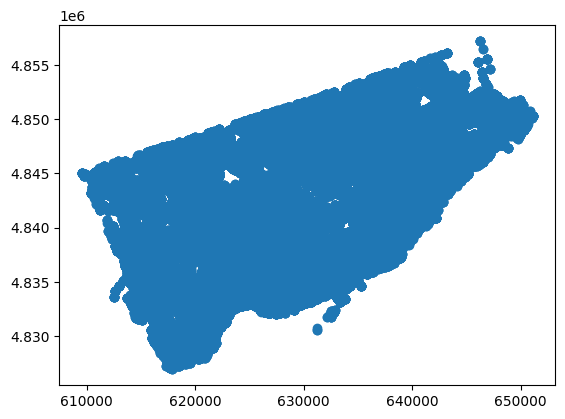

In [20]:
#plot our new data
#assign the proper projection for the area
collision_26917 = gpd.GeoDataFrame(collision_agg)
collision_26917 = collision_26917.to_crs(epsg=26917)
collision_26917.plot()

#### Combining Traffic Data with Collision Data




Here we have another example of dividing features into groups by a value, in this case by the year, and combining them by proximity.

The difference with this example is that if it were to be done manually, the time needed to join them would be significant.  
To be done manually would invole filtering each data set by a year, extracting the data to new layers, and then performing the join  
between the two. Repeat this process for each year, and then combined all the years together for the finalized dataset.

Rather than do that, we seperate by value and iterate through the years, discarding data if a year is not present.

We join right onto the collision data set, so that each collision point now has a location_id that we can use to combine points that  
meant to represent the same location.


In [21]:
#split each dataframe into groups
col_split = {k:d for k, d in collision_26917.groupby('year')}
traf_split = {k:d for k, d in traffic_26917.groupby('year')}

#our new, empty, dataset
combined = pd.DataFrame()
for i in traf_split:
    #try is needed for when a road is present in on group, but not the other
    #causing a key value error
    try:
        #if shared road is present AND wihtin the distance then add to an already existing dataframe
        #we merge on right because we want each collision point to have a location_id
        combined = pd.concat([combined, gpd.sjoin_nearest(traf_split[i], col_split[i], max_distance=10, how='right')])
    except:
        #otherwise we didn't need to add the data and can pass over it
        combined = pd.concat([combined, traf_split[i]])


#reset index to remove groups
combined = combined.reset_index()

#concating the data leads to some misformating, this fixes it, by grabbing the field with data
combined['year'] = np.nanmax([combined['year'], combined['year_left'], combined['year_right']], axis=0)
#drop un-needed columns
combined = combined.drop(columns=['year_right', 'year_left', 'index_left'])

combined.head(-4)

,index,year,location_id,count_id,location,lng,lat,centreline_type,centreline_id,motortraf,geometry,_id1,HOOD_1512,NEIGHBO13,motorcol,fatals,injuries
0,0,1990.0,3943.0,2896,OCONNOR DR AT ST CLAIR AVE (PX 447),-79.312836,43.705396,2.0,13457092.0,25543.0,POINT (635935.311 4840535.754),NaN,NaN,NaN,NaN,NaN,NaN
1,1,1990.0,3950.0,2899,KINGSTON RD AT BROOKLAWN AVE & ST CLAIR AVE E ...,-79.236019,43.722032,2.0,13454337.0,23234.0,POINT (642085.246 4842512.259),NaN,NaN,NaN,NaN,NaN,NaN
2,2,1990.0,3976.0,3139,EGLINTON SQ AT O CONNOR DR & VICTORIA PARK AVE...,-79.302100,43.723380,2.0,13454288.0,23507.0,POINT (636759.408 4842550.798),NaN,NaN,NaN,NaN,NaN,NaN
3,3,1990.0,3977.0,3178,DANFORTH AVE AT VICTORIA PARK AVE (PX 355),-79.288358,43.691232,2.0,13459445.0,22429.0,POINT (637940.014 4839003.071),NaN,NaN,NaN,NaN,NaN,NaN
4,4,1990.0,3978.0,3243,EGLINTON AVE AT VICTORIA PARK AVE (PX 451),-79.302645,43.724723,2.0,13454107.0,38630.0,POINT (636712.455 4842699.059),NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118091,102845,2024.0,4207.0,101620,BAY ST AT HARBOUR SQ & QUEENS QUAY (PX 2416),-79.376841,43.641152,2.0,13468022.0,9567.0,MULTIPOINT (630919 4833297.275),685827.0,166,St Lawrence-East Bayfront-The Islands (166),16.0,0.0,1.0
118092,102846,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIPOINT (631090.311 4833389.868),686995.0,166,St Lawrence-East Bayfront-The Islands (166),15.0,0.0,0.0
118093,102847,2024.0,38125.0,101517,FREELAND ST AT QUEENS QUAY E,-79.373042,43.642491,2.0,13467854.0,7821.0,MULTIPOINT (631223.027 4833455.654),686910.0,166,St Lawrence-East Bayfront-The Islands (166),4.0,0.0,0.0
118094,102848,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIPOINT (630666.802 4833161.666),682244.0,166,St Lawrence-East Bayfront-The Islands (166),3.0,0.0,0.0


#### Cleaning Collisions with Traffic Locaiton ID

By assigning each collision point a location ID that is used by the traffic dataset, we can recombine points that represent the same
location back into each other, after we merge back into the traffic dataset.

<Axes: >

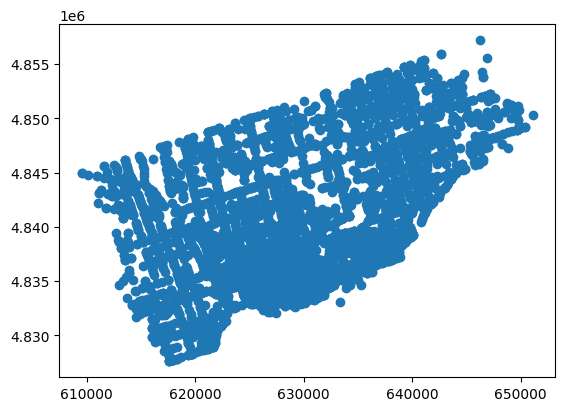

In [22]:
#keep only data we need
traffic_collision = combined[['year', 'location_id', 'HOOD_1512', 'NEIGHBO13', 'centreline_id', 'motorcol', 'fatals', 'injuries']]

#add the collision data back into traffic data using the new shared ids
format_traf_col = traffic_26917.merge(traffic_collision, how='left', on=['year', 'location_id'], validate='1:m', suffixes=('_l', '_r'))

#aggregate by year and location id once more to combine collision data together on the same location
#the function grabs the first value in a datafram, since we dont care which we grab when aggregating.
def first_val(x):
    return x.iloc[0]

col_traf_agg = format_traf_col.groupby(['year','location_id']).agg({'count_id': first_val,
                                                                    'location': first_val,
                                                                    'centreline_id_r': first_val,
                                                                    'HOOD_1512': first_val,
                                                                    'NEIGHBO13': first_val,
                                                                    'motortraf': 'sum',
                                                                    'motorcol':'sum',
                                                                    'fatals':'sum',
                                                                    'injuries': 'sum',
                                                                    'geometry': first_val})
#reset to remove groups
col_traf_agg = col_traf_agg.reset_index()
#fix formatting
col_traf_agg = col_traf_agg.rename(columns={'centreline_id_r':'centreline_id_r'})

#our new data
traffic_collision = gpd.GeoDataFrame(col_traf_agg)
traffic_collision = traffic_collision.set_crs(epsg=26917)

#checking to see we still have data after the merge
col_traf_map = traffic_collision.query('motortraf > 0 & motorcol > 0')
col_traf_map.plot()

## Joining Traffic and Collision Point Data to Road line Data

We need to join collisions to roads. Since collisions are offset to the nearest intersection there will be multiple roads  
sharing the same intersection counts. 

Since we do not know which direction a car was coming from for collisions we assumed the same for traffic when combining the two.  
We will also assume that any intersection connected to a road contributes to its overall traffic and collisions.

This can be problamatic in cases where a minor road is attached to a major road, and the majority of collision  
at an intersection are caused by the major road. This may lead to inflated counts for minor roads, but unless a minor road  
is exlcusively surrounding by high traffic roads, it will still have an overall lower count when compared to major roads.

Major roads surrounded by minor roads will not be as influenced as we will assume that major roads   
will be connected to other major roads, and therefore have greater traffic counts when compared to minor roads.

<Axes: >

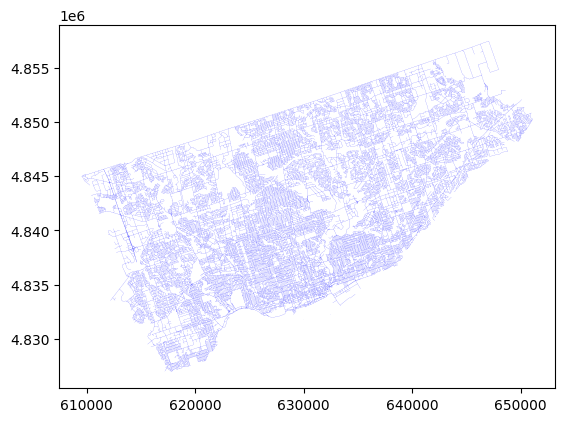

In [26]:
#create buffer around each road
road_26917_buffer = road_26917.copy()
road_26917_buffer['geometry'] = road_26917_buffer['geometry'].buffer(5)
road_26917_buffer.plot(color='blue')


In [25]:
road_26917_buffer.head()

,CENTREL2,LINEAR_3,LINEAR_4,LINEAR_5,LINEAR_26,LINEAR_30,FROM_IN31,TO_INTE32,FEATURE35,FEATURE36,JURISDI37,OBJECTI39,MI_PRIN40,geometry,calm_id,spd_hump,traf_islan,spd_cush,Installed
0,914600,2141,Morrison St,Morrison Street,Morrison,Morrison St,13470555,13470560,201500,Local,CITY OF TORONTO,1,1,"POLYGON ((620277.174 4828210.441, 620276.699 4...",NaN,NaN,NaN,NaN,NaN
1,914601,2666,Twelfth St,Twelfth Street,Twelfth,Twelfth St,13470560,13470530,201500,Local,CITY OF TORONTO,2,2,"POLYGON ((620230.306 4828339.006, 620230.177 4...",NaN,NaN,NaN,NaN,NaN
2,7862398,2611,Thirteenth St,Thirteenth Street,Thirteenth,Thirteenth St,13470571,13470538,201500,Local,CITY OF TORONTO,3,3,"POLYGON ((620150.489 4828311.727, 620150.362 4...",NaN,NaN,NaN,NaN,NaN
3,914587,1962,Lake Shore Blvd W,Lake Shore Boulevard West,Lake Shore,Lake Shore Blvd W,13470546,13470552,201200,Major Arterial,CITY OF TORONTO,6,6,"POLYGON ((619527.788 4828252.379, 619527.315 4...",NaN,NaN,NaN,NaN,NaN
4,6735911,1962,Lake Shore Blvd W,Lake Shore Boulevard West,Lake Shore,Lake Shore Blvd W,13470552,13470558,201200,Major Arterial,CITY OF TORONTO,7,7,"POLYGON ((619439.831 4828222.367, 619439.359 4...",NaN,NaN,NaN,NaN,NaN


By using a copy of the roads dataset, we can recreate the roads with a buffer of 5 meters. We then join any points within them  
combining any traffic and collision date within their range.

In [26]:
#use buffer to get all point within the polygon
buffer_with_data = gpd.sjoin(road_26917_buffer, traffic_collision, how='right')
buffer_with_data = buffer_with_data[['CENTREL2', 'year', 'motortraf', 'motorcol','fatals','injuries']]

#aggregate
buffer_agg = buffer_with_data.groupby(['CENTREL2', 'year']).agg('sum')
buffer_agg = buffer_agg.reset_index()
#join back to roads
all_roads = road_26917.merge(buffer_agg, how='left', on=['CENTREL2'], validate='1:m', suffixes=('_l', '_r'))

plot the data to visually check that it is identical to the road_26917 dataframe, as it should be.

<Axes: >

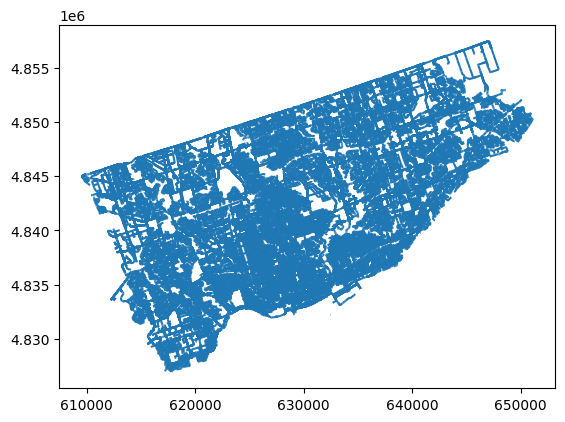

In [27]:
all_roads.plot()

#### Calculating Collision Rate

For any road with both traffic counts and collison data we will find the rate of collision.
We will do it per 100,000 so that the values are readable, especially for roads that see very low  
rates of collision.

In [28]:
#calculate the collision rate for each road
#collision rate is per 100,000 cars
all_roads['col_rate'] = all_roads['motorcol']/all_roads['motortraf']*100000

#for all calmed roads, calculate the collision rate before it was installed and after
all_roads['colrt_bfr'] = all_roads.query('Installed - year == 1 ')['col_rate']
all_roads['colrt_aft'] = all_roads.query('year - Installed == 1 ')['col_rate']

all_roads.head(-5)

,CENTREL2,LINEAR_3,LINEAR_4,LINEAR_5,LINEAR_26,LINEAR_30,FROM_IN31,TO_INTE32,FEATURE35,FEATURE36,JURISDI37,OBJECTI39,MI_PRIN40,geometry,calm_id,spd_hump,traf_islan,spd_cush,Installed,year,motortraf,motorcol,fatals,injuries,col_rate,colrt_bfr,colrt_aft
0,914600,2141,Morrison St,Morrison Street,Morrison,Morrison St,13470555,13470560,201500,Local,CITY OF TORONTO,1,1,"LINESTRING (620365.778 4828243.398, 620275.681...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,914601,2666,Twelfth St,Twelfth Street,Twelfth,Twelfth St,13470560,13470530,201500,Local,CITY OF TORONTO,2,2,"LINESTRING (620275.681 4828215.213, 620235.062...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7862398,2611,Thirteenth St,Thirteenth Street,Thirteenth,Thirteenth St,13470571,13470538,201500,Local,CITY OF TORONTO,3,3,"LINESTRING (620195.613 4828188.199, 620155.247...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,914587,1962,Lake Shore Blvd W,Lake Shore Boulevard West,Lake Shore,Lake Shore Blvd W,13470546,13470552,201200,Major Arterial,CITY OF TORONTO,6,6,"LINESTRING (619614.26 4828286.233, 619526.218 ...",NaN,NaN,NaN,NaN,NaN,2019.0,8614.0,2.0,0.0,0.0,23.218017,NaN,NaN
4,914587,1962,Lake Shore Blvd W,Lake Shore Boulevard West,Lake Shore,Lake Shore Blvd W,13470546,13470552,201200,Major Arterial,CITY OF TORONTO,6,6,"LINESTRING (619614.26 4828286.233, 619526.218 ...",NaN,NaN,NaN,NaN,NaN,2022.0,7573.0,1.0,0.0,0.0,13.204807,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99061,60005935,8574,Neilson Rd,Neilson Road,Neilson,Neilson Rd,13445271,13445040,201300,Minor Arterial,CITY OF TORONTO,259825,259825,"LINESTRING (644396.132 4849419.184, 644326.929...",NaN,NaN,NaN,NaN,NaN,2018.0,9464.0,7.0,0.0,1.0,73.964497,NaN,NaN
99062,60005967,7835,Ellesmere Rd,Ellesmere Road,Ellesmere,Ellesmere Rd,13445401,13445166,201200,Major Arterial,CITY OF TORONTO,259827,259827,"LINESTRING (644439.968 4849293.103, 645091.375...",NaN,NaN,NaN,NaN,NaN,1990.0,15880.0,0.0,0.0,0.0,0.000000,NaN,NaN
99063,60005967,7835,Ellesmere Rd,Ellesmere Road,Ellesmere,Ellesmere Rd,13445401,13445166,201200,Major Arterial,CITY OF TORONTO,259827,259827,"LINESTRING (644439.968 4849293.103, 645091.375...",NaN,NaN,NaN,NaN,NaN,1994.0,18448.0,0.0,0.0,0.0,0.000000,NaN,NaN
99064,60005967,7835,Ellesmere Rd,Ellesmere Road,Ellesmere,Ellesmere Rd,13445401,13445166,201200,Major Arterial,CITY OF TORONTO,259827,259827,"LINESTRING (644439.968 4849293.103, 645091.375...",NaN,NaN,NaN,NaN,NaN,1996.0,17301.0,0.0,0.0,0.0,0.000000,NaN,NaN


# Analysis

This Section of the notebook is concerned with the analysis of that data.  
We now have all the data we need, so we will be extracting the data  
based on the maps we will make the analysis we want.

Specifically we want data from 2023, as it is the most recent full years worth of data.
We also want max Traffic and Collision Rate from all time.

'all_traffic' will have the highest motor counts per road from any year, as well as the year it was achieved.

In [29]:
#copy data from all_roads
all_traffic = all_roads[['CENTREL2', 'LINEAR_5', 'motortraf','geometry']]
#aggregate data to retrieve the highest motorcount (traffic) from any year
all_traffic = all_traffic.groupby(['CENTREL2']).agg({'LINEAR_5':pd.Series.mode, 'motortraf':'max', 'geometry': pd.Series.mode, })
all_traffic = all_traffic.reset_index()
#turn the dataframe back into a geodata fram after aggregating
all_traffic = gpd.GeoDataFrame(all_traffic)
all_traffic = all_traffic.set_crs(epsg=26917)
#retrieve the year that the motor count came from, by using the traffic count and road id
all_traffic = all_traffic.merge(all_roads[['CENTREL2','year', 'motortraf']], how='left', on=['motortraf', 'CENTREL2'])
all_traffic = all_traffic[['CENTREL2', 'LINEAR_5', 'year', 'motortraf','geometry']]

Like 'all_traffic', 'all_col_rate' will have the highest collision rate per road from any year, as well as the year it was achieved.

In [30]:
#copy data from all_roads
all_col_rate = all_roads[['CENTREL2', 'LINEAR_5', 'col_rate','geometry']]
#aggregate data to retrieve the highest motorcount (traffic) from any year
all_col_rate = all_col_rate.groupby(['CENTREL2']).agg({'LINEAR_5':pd.Series.mode, 'col_rate':'max', 'geometry': pd.Series.mode, })
all_col_rate = all_col_rate.reset_index()
#turn the dataframe back into a geodata fram after aggregating
all_col_rate = gpd.GeoDataFrame(all_col_rate)
all_col_rate = all_col_rate.set_crs(epsg=26917)
#retrieve the year that the motor count came from, by using the traffic count and road id
all_col_rate = all_col_rate.merge(all_roads[['CENTREL2','year', 'col_rate']], how='left', on=['col_rate', 'CENTREL2'])
all_col_rate = all_col_rate[['CENTREL2', 'LINEAR_5', 'year', 'col_rate','geometry']]

'normal_roads' and 'calmed_roads' will have data only for that type of road for mapping purposes.

'normal_data' and 'calm_data' represent the same features, but for plotting purposes. 'data' being the two combined.

In [31]:
#return only normal roads and format dataframe
normal_roads = all_roads.query('year == 2023 & Installed.isna()')
normal_roads['type'] = 'normal'
normal_roads['col_rate'] = round(normal_roads['col_rate'],2)

#return only calmed roads and format dataframe
calmed_roads = all_roads.query('year == 2023 & Installed < 2023')
calmed_roads['type'] = 'calmed'
calmed_roads['col_rate'] = round(calmed_roads['col_rate'],2)

#dataframes for the matplot
normal_data = normal_roads[['col_rate', 'type']]
calm_data = calmed_roads[['col_rate', 'type']]
#combined if needed
data = pd.concat([normal_data, calm_data])

#geo dataframes combined if needed
#map_data = pd.concat([normal_roads, calmed_roads])
#return columns that we want to show
#map_data = map_data[['LINEAR_5','year', 'FEATURE36','type', 'calm_id', 'Installed', 'motortraf', 'motorcol', 'col_rate', 'fatals', 'injuries', 'geometry']]


We gather the statistical summuries of the both data sets, which help us interpret the plots.

In [32]:
data.groupby('type').describe()

col_rate                                                            
          count       mean         std  min    25%    50%     75%       max
type                                                                       
calmed     39.0  58.858205  139.940272  0.0   0.00  29.58   55.68    862.07
normal   2444.0  93.091919  424.878205  0.0  14.91  51.07  106.40  13413.17

In [33]:
#set our graph style
sns.set_style('whitegrid')

A frequency Histogram helps visualize the distributions of how often  
certain collison rates occur. Here we see that most roads have a low collision rate,  
which is expected, if not apprecaited.

Both datasets share a visually similar distribution.  
We also see that the frequency slowly ramps down for both, visually similar to a right  
skewed normal distribution graph.

(0.0, 1600.0)

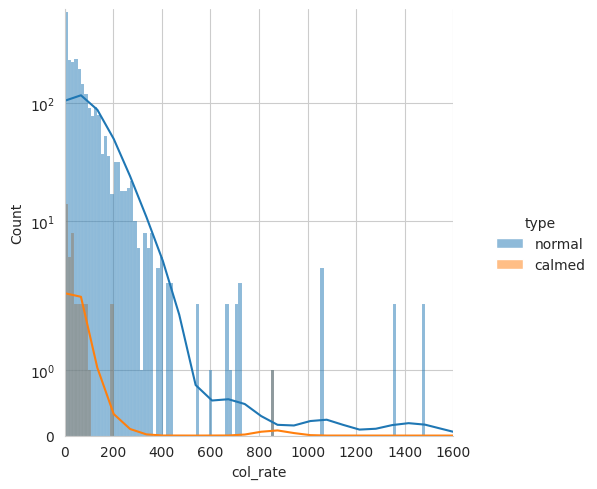

In [34]:
sns.displot(data=data, x="col_rate",hue='type', kde=True)
plt.yscale("symlog")
plt.xlim(0, 1600)

Once again, in the box plots we see that both data sets are skewed right,  
with a greater distribution around lower collision rates. 

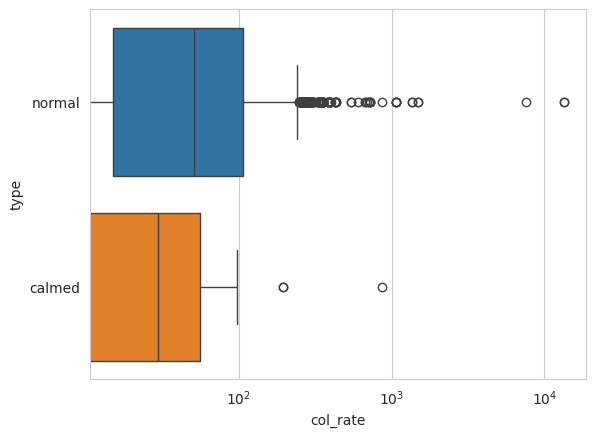

In [35]:
ax = sns.boxplot(x='col_rate',y='type', hue=data['type'],data=data)
plt.xscale('log')

Violin plots with a strip plot provide similar data to boxplots,  
but helps better visualize where the data groups around.

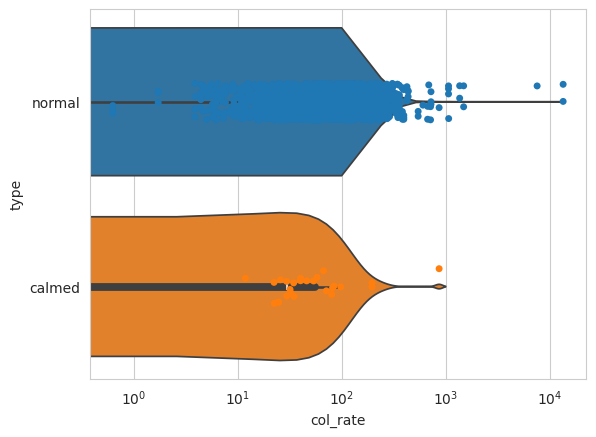

In [36]:
ax = sns.violinplot(x='col_rate',y='type', hue=data['type'], data=data)
ax = sns.stripplot(x='col_rate',y='type', hue=data['type'], data=data)
plt.xscale('log')

Probability plots are also great tools to identify distributions of data.  
In this case we also see a heavy distribution of low collison rate streets.

More importantly we see that the data does not follow a normal distribution.  
The further from the mean you go the more exteme the collision rates should be,   
Whether lower or higher. This would result in a straigt line, as data would be evenly  
distributed from z scores of -3 to 3.

This alligns with what we saw in the above graphs, that data is bunched towards  
the lower values. But in both cases they follow a similar distribution

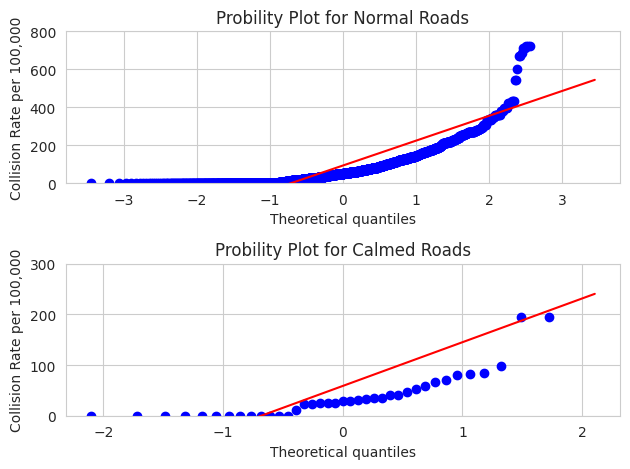

In [37]:
ax1 = plt.subplot(211)
res = scipy.stats.probplot(normal_data['col_rate'], plot=plt) 

ax2 = plt.subplot(212)
res2 = scipy.stats.probplot(calm_data['col_rate'], plot=plt)

ax1.set_title("Probility Plot for Normal Roads")
ax1.set_ylabel('Collision Rate per 100,000')

ax2.set_title("Probility Plot for Calmed Roads")
ax2.set_ylabel('Collision Rate per 100,000')

ax1.set_ylim([0, 800]) #to zoom in and see data
ax2.set_ylim([0, 300]) #to zoom in and see data

plt.tight_layout()


### Two Sample T-test

We will perform a two sample right tail t-test. What this means is that we will assert that:
- Null hypothesis: Both means are the same, or
- Alternative hypothesis: The mean for collision rates on normal roads is higher

It is two sample as both normal road data and calm road data are samples of all road data found in Toronto,  
something that is unknown, since not every road has data.

With the information we have we know that the data skews positively and that from the  
statistics summary the variation data differs to much from one another, so the t-test  
must be an unequal variance t-test, also known as Welch’s t-test.

Our alpha will be set to 0.05, meaning we are 95% confident.  
If the p-value from our result is lower than the alpha we reject  
the null hypothesis and accept the alternative hypothesis.


In [38]:
alpha= 0.05

t_statistic, p_value = pystat.ttest_ind(normal_data['col_rate'], calm_data['col_rate'], alternative='greater', equal_var=False)


# Output the results
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("There is a significant difference between the collison rates.")
else:
    print("There is no significant difference between the collsion rates.")

t-statistic: 1.4264065905488366
P-value: 0.07998370304737284
There is no significant difference between the collsion rates.


From these results we can assert that the mean of both groups are not different enough that they represent different  
populations. Because the p_value > 0.05, the average of collision rates for normal roads is equal to that of calmed roads.

But just because calmed roads have an equal rate of collisions, it doesn't mean that calming features don't have an effect.  
There could be a variety of factors. We can map the data and look for reasons as to why.

In [45]:
popup_data = ["LINEAR_5",'JURISDI37','calm_id', 'spd_hump', 'traf_islan','spd_cush', "type", 'year', 'motortraf','Installed', 'motorcol', "col_rate"]
m = normal_roads.explore(
    column="col_rate",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True, 
    cmap = 'spring_r',
    tooltip=["LINEAR_5", "type",'motortraf', 'motorcol', "col_rate"],
    popup=popup_data,  # show popup (on-click)
    name="Normal Roads Collision Rates in 2023",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Normal Roads Collision Rate per 100,000',
                'scale':False,
                },
    style_kwds={'weight': 5}
)

m = normal_roads.explore(
    column="motortraf",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True, 
    cmap = 'spring_r',
    tooltip=["LINEAR_5", "type",'motortraf', 'motorcol', "col_rate"],
    popup=popup_data,  # show popup (on-click)
    name="Normal Roads Traffic Count in 2023",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Normal Roads Traffic Count',
                'scale':False,
                },
    style_kwds={'weight': 5},
    m=m
)

m = calmed_roads.explore(
    column="col_rate", 
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  
    cmap='summer_r',
    tooltip=["LINEAR_5", "type",'motortraf', 'motorcol', "col_rate"],
    popup=popup_data,  # show popup (on-click)
    name="Calmed Roads Collision Rates in 2023",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Calmed Roads Collision Rate per 100,000',
                'scale':False,
                },
    style_kwds={'weight': 5},
    m=m
)

m = calmed_roads.explore(
    column="motortraf",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    cmap = 'summer_r',
    tooltip=["LINEAR_5", "type",'motortraf', 'motorcol', "col_rate"],
    popup=popup_data,  # show popup (on-click)
    name="Calmed Roads Traffic Count in 2023",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Calmed Roads Traffic Count',
                'scale':False,
                },
    style_kwds={'weight': 5},
    m=m
)



folium.LayerControl().add_to(m)


#file is too large for notebook
m.save('Toronto_Traffic_Collisions.html')

The map 'Toronto_Traffic_Collisions.html' shows that many of the calmed roads with high collision rates happen to be near roads with high traffic, taken from the all_traffic layer.

What is the correlation between the two?

In [40]:
correlation_data = calmed_roads[['motortraf', 'motorcol', 'col_rate', 'fatals', 'injuries']]
correlation_data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,motortraf,motorcol,col_rate,fatals,injuries
motortraf,1.000000,0.312909,0.669447,NaN,0.066424
motorcol,0.312909,1.000000,0.707355,NaN,0.562448
col_rate,0.669447,0.707355,1.000000,NaN,0.352848
fatals,NaN,NaN,NaN,NaN,NaN
injuries,0.066424,0.562448,0.352848,NaN,1.000000


In [41]:
correlation_data = normal_roads[['motortraf', 'motorcol', 'col_rate', 'fatals', 'injuries']]
correlation_data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,motortraf,motorcol,col_rate,fatals,injuries
motortraf,1.000000,0.091351,0.715786,-0.039840,-0.035064
motorcol,0.091351,1.000000,0.208260,0.047986,0.566223
col_rate,0.715786,0.208260,1.000000,-0.011151,0.092918
fatals,-0.039840,0.047986,-0.011151,1.000000,0.036139
injuries,-0.035064,0.566223,0.092918,0.036139,1.000000


We can see for both types of roads, motor traffic does indeed have a high correlation with collision rate. Another observation is that  
although the number of collisions is moderately correlated to traffic in normal roads, there is a higher correlation in calmed roads. The same  
is true for traffic and collision rates.

In both types of roads, the correlation between collison and injuries are nearly the same, with them being strongly correlated. This seems intuive  
until you consider that in both types fatalities are weakly correlated. This could be due to the fact that those who get transported  
to hospitals are not recorded as fatalities, so only the extreme cases which may happen rarely remain.  

Ultimately from these observations we can infer that calmed roads in general are safer, with a lower average for collision rates.   
This does not extend to the observation that our t-test was wrong, but rather they may have been other factors at play the influenced    
the outcome. 

But if we were to implment road calming features, which roads would we choose?

In [42]:
#we made the normal roads traffic again
m = normal_roads.explore(
    column="motortraf",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    cmap = 'spring_r',
    tooltip=["LINEAR_5", "type","motortraf", "motorcol", "col_rate"],
    popup=True,  # show popup (on-click)
    name="2023 Normal Roads Traffic Count",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Traffic Count',
                'scale':False,
                },
    style_kwds={'weight': 5}
)
m = calmed_roads.explore(
    column="motortraf",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    cmap = 'summer_r',
    tooltip=["LINEAR_5", "type",'motortraf', 'motorcol', "col_rate"],
    popup=True,  # show popup (on-click)
    name="Calmed Roads Traffic Count",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'2023 Calmed Roads Traffic Count',
                'scale':False,
                },
    style_kwds={'weight': 5},
    m=m
)

folium.LayerControl().add_to(m)


#file is too large for notebook
m.save('Toronto_Traffic.html')

The above map 'Toronto_Traffic.html' highlights high traffic roads both with and without calming features.  
The normal roads without calming features could be considered candidates.

And finally what were the highest traffic counts and collision rates for roads throughout the years?\
How do calmed roads compare to this?

In [43]:
m = all_traffic.explore(
    column="motortraf",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True, 
    cmap = 'spring_r',
    tooltip=["LINEAR_5",'year', 'motortraf'],
    popup=True,  # show popup (on-click)
    name="Highest Traffic Counts",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Highest Traffic Count',
                'scale':False,
                },
    style_kwds={'weight': 5}
)

m = calmed_roads.explore(
    column="motortraf",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    cmap = 'summer_r',
    tooltip=["LINEAR_5", "type",'motortraf'],
    popup=True,  # show popup (on-click)
    name="2023 Calmed Roads Traffic Count",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Calmed Roads Traffic Count',
                'scale':False,
                },
    style_kwds={'weight': 5},
    m=m
)
folium.LayerControl().add_to(m)
m.save('Highest_Traffic_Toronto.html')

In [44]:
m = all_col_rate.explore(
    column="col_rate",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True, 
    cmap = 'spring_r',
    tooltip=["LINEAR_5",'year', 'col_rate'],
    popup=True,  # show popup (on-click)
    name="Highest Collision Rates",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Highest Traffic Count',
                'scale':False,
                },
    style_kwds={'weight': 5}
)

m = calmed_roads.explore(
    column="col_rate",
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    legend=True,  # show legend
    cmap = 'summer_r',
    tooltip=["LINEAR_5", "type",'col_rate'],
    popup=True,  # show popup (on-click)
    name="2023 Calmed Roads Collision Rates",  # name of the layer in the map
    legend_kwds={'colorbar':True,
                'caption':'Calmed Roads Traffic Count',
                'scale':False,
                },
    style_kwds={'weight': 5},
    m=m
)
folium.LayerControl().add_to(m)
m.save('Highest_Collision_Rate_Toronto.html')

For 'Highest_Collision_Rate_Toronto.html' and 'Highest_Traffic_Toronto.html':  

Some Calmed Roads from 2023 coincide with the highest traffic counts of all time,  
such as on Balmoral Avenue and Merton Street, but mostly every other calmed road has decreased from its peak.

When examining Collision Rates, the same two roads have lower collision rates in 2023, than they do at their peak.  
This shows evidence that calmed features are doing their job and the with increased traffic, these two roads are  
now safer. Some exceptions being Vesta Drive and Mayfair Avenue, which now have higher collison rates, although their traffic  
counts are down from their peak. 



## Conclusion

So how do our observations stack up against our t-test result? There may have been a variety of factors at play, 
but the main one to consider is our decision to aggregate traffic and collsion data with road data, regardless of direction.

A major observation in each of the maps above is that many minor roads off of major roads had a higher number of traffic  
and collision. This is to be expected, but at times they were on par with the major roads. This is most likely an error
with our assumption that minor roads would not be as effectinv by the grouping of traffic and collision data.

It is difficult to recitfy this as collision data is on a per interseciton bases, and the directional data for traffic  
is not geographcially tied, but rather a seperate field for whther or not a vehicle was entering or leaving the intersection.  

There can be room for improvenment in our analysis, but as it stands this notebook offers a showcase of the methods, and reasoning  
used to reach our conslusion, that the mean rate of collision of both groups are equal.



###### This Notebook contains original analysis by Nelson Alesandro, 2024.

###### Data within this notebook is from the City of Torontos Open Data set.